# Custom Propagator
#### Too slow with drag model

In [ ]:
using GeneticDeorbit
using Plots

In [ ]:
@show exponential_atmosphere_density(0.0)
@show exponential_atmosphere_density(150000.0)
@show exponential_atmosphere_density(350000.0)
@show exponential_atmosphere_density(600000.0)

In [ ]:
# Propagate for 10 days. Thrust is assumed in the negative intrack direction
tspan = (0.0,10*24*60.0*60.0)
ephem = cowellsprop(initialstate_rv_eci, thrust1_m_s_s, tspan)

@time begin
    ephem = cowellsprop(initialstate_rv_eci, thrust1_m_s_s, tspan)
end

In [ ]:
t = ephem.t
states = ephem.u
x  = []
y  = []
z  = []
vx = []
vy = []
vz = []
for state in states
    push!(x,state[1])
    push!(y,state[2])
    push!(z,state[3])
    push!(vx,state[4])
    push!(vy,state[5])
    push!(vz,state[6])
end

plt = plot3d(x,y,z,
    title = "Earth Orbit",
    marker = 2,
)

# Julia Propagator
#### SatelliteDynamics.jl doesn't work for current dates because it isnt maintained....

In [ ]:
using Pkg
Pkg.activate("/home/lism8025/Documents/Projects/GeneticDeorbit")
using GeneticDeorbit
import GeneticDeorbit: throttle # need to import to extend method
using SatelliteDynamicsLCS
using StaticArrays
using Plots

In [ ]:
# Declare simulation initial Epoch and state
epoch0 = Epoch(2015, 4, 25, 12, 0, 0, 0.0) 
epochf = epoch0 + 120*24*60*60
r0 = SVector{3,Float64}(2712241.37, -358426.60, -6318958.88) # m
v0 = SVector{3,Float64}(3891.70, 6403.93, 1265.18) # m/s
s0_eci = [r0[1], r0[2], r0[3], v0[1], v0[2], v0[3]]


In [ ]:
burn_duration = 2*360*pi/180
switching_alt = 400e3
#EarthInertialState orbit propagagator
orb  = EarthInertialState(epoch0, s0_eci, dt=60.0,
            mass=500.0, area_drag = 25.0, n_grav=0, m_grav=0,
            drag=true, srp=false,
            moon=false, sun=false,
            relativity=false,
            thrust_m_s_s = 0.100/500,
            throttle = x -> throttle(x, pi, burn_duration, switching_alt)
)
reinit!(orb);

In [ ]:
t = []
epc = []
eci = []
@time begin
    t, epc, eci = sim!(orb, epochf)
end
t[end]
#plot3d(eci[1,:],eci[2,:],eci[3,:],)

In [ ]:
t[end]/60/60/24

In [ ]:
plot3d(eci[1,:],eci[2,:],eci[3,:],)

In [ ]:
using LinearAlgebra
rp = []
ra = []
ecc = []
θ = []
T = []
for i = 1:size(eci)[2]
    state = eci[:,i]
    r = state[1:3]
    v = state[4:6]
    rmag = norm(r)
    h = cross(r,v)
    hmag = norm(h)
    e = cross(v,h)/μ - r/rmag
    emag = norm(e)
    rpi = hmag^2/μ * (1/1-emag)
    rai = hmag^2/μ * (1/1+emag)
    
    θi = acos(dot(e, r) / (emag * rmag))
    if dot(r, v) < 0
        θi = 2*pi - θi
    end
    push!(θ, θi)
    push!(T,throttle(state, pi, burn_duration, switching_alt))
    push!(rp,rpi-R_EARTH)
    push!(ra,rai-R_EARTH)  
    push!(ecc,emag)
end

In [ ]:
findall(x-> x<200e3,ra)[1]
t[33443]

In [ ]:
plt = plot(t,rp./1e3,label="rp")
plot!(plt,t,ra./1e3, label="ra")

In [ ]:
plot(ecc)

In [ ]:
ind = 36000
plot(t[1:ind],[θ[1:ind], 2*pi*T[1:ind]])

In [ ]:
sum(T)

In [ ]:
normalizer = [2.00652e6, 5137]
weights = [0.5, 0.5] # 100% on time, 0% on throttle

In [ ]:
weights./normalizer

In [ ]:
using Pkg
Pkg.activate("/home/lism8025/Documents/Projects/GeneticDeorbit")
using GeneticDeorbit

In [ ]:
# 100-0
normalizer = [2.00652e6, 5137]
weights = [1.0, 0.0]./normalizer # 100% on time, 0% on throttle
opt_sc = spacecraft(423049.9145386597, 1.609833282251075)
opt_traj = eval_fitness(opt_sc, weights)
genehist1 = [[300300.75104847713, 280179.75061807263, 413495.19440271734, 440752.3968933157, 321383.7959935098, 359313.9954447062, 334356.5319364604, 318017.34535724565, 259242.45920113593, 351144.39246197883, 300815.5732861961, 437961.02892182523, 408456.3387641392, 314039.7521728904, 333592.6679438651, 318965.44407925487, 396442.4018449896, 332030.42011521617, 360313.34872420295, 334049.0254363711],
 [425728.1116622713, 425728.1116622713, 408456.3387641392, 413495.19440271734, 423208.6838429822, 423208.6838429822, 356897.9727255972, 356897.9727255972, 385776.8484328452, 385776.8484328452, 399137.1888230141, 399137.1888230141, 373793.3971534842, 373793.3971534842, 315662.07154002576, 315662.07154002576, 413495.19440271734, 408456.3387641392, 440752.3968933157, 333592.6679438651],
 [378017.5807743056, 378017.5807743056, 413495.19440271734, 423208.6838429822, 423208.6838429822, 413495.19440271734, 385196.58356415725, 385196.58356415725, 399636.02141778124, 399636.02141778124, 413495.19440271734, 413495.19440271734, 424468.3977526268, 424468.3977526268, 415832.5113035607, 415832.5113035607, 423208.6838429822, 423208.6838429822, 413495.19440271734, 413495.19440271734],
 [423838.5407978045, 423838.5407978045, 411422.3526303817, 411422.3526303817, 395756.38758851145, 395756.38758851145, 423208.6838429822, 413495.19440271734, 413495.19440271734, 399636.02141778124, 378017.5807743056, 423208.6838429822, 423208.6838429822, 413495.19440271734, 423208.6838429822, 423208.6838429822, 423208.6838429822, 423208.6838429822, 423208.6838429822, 423208.6838429822],
 [399636.02141778124, 423208.6838429822, 417315.51823668194, 417315.51823668194, 423523.6123203933, 423523.6123203933, 423208.6838429822, 423208.6838429822, 423208.6838429822, 423208.6838429822, 418666.8676002609, 418666.8676002609, 423208.6838429822, 423208.6838429822, 423523.6123203933, 423523.6123203933, 423208.6838429822, 423208.6838429822, 423208.6838429822, 423208.6838429822],
 [423208.6838429822, 423208.6838429822, 421095.2399603271, 421095.2399603271, 420937.7757216216, 420937.7757216216, 423366.14808168774, 423366.14808168774, 423208.6838429822, 423208.6838429822, 420262.1010398321, 420262.1010398321, 423366.14808168774, 423366.14808168774, 423366.14808168774, 423366.14808168774, 423208.6838429822, 423208.6838429822, 423208.6838429822, 423208.6838429822],
 [422151.96190165466, 422151.96190165466, 423287.41596233496, 423287.41596233496, 423208.6838429822, 423208.6838429822, 423366.14808168774, 423366.14808168774, 423287.41596233496, 423287.41596233496, 423287.41596233496, 423287.41596233496, 423208.6838429822, 423208.6838429822, 421016.5078409744, 421016.5078409744, 423208.6838429822, 423208.6838429822, 423366.14808168774, 423366.14808168774],
 [423248.04990265856, 423248.04990265856, 423326.78202201135, 423326.78202201135, 422759.05499167123, 422759.05499167123, 422112.5958419783, 422112.5958419783, 421016.5078409744, 423208.6838429822, 423248.04990265856, 423248.04990265856, 423287.41596233496, 423287.41596233496, 421016.5078409744, 423287.41596233496, 423287.41596233496, 423287.41596233496, 423208.6838429822, 423208.6838429822],
 [423208.6838429822, 423287.41596233496, 422151.96190165466, 422151.96190165466, 423208.6838429822, 423287.41596233496, 423287.41596233496, 423287.41596233496, 422759.05499167123, 422759.05499167123, 423267.73293249676, 423267.73293249676, 423287.41596233496, 423287.41596233496, 422435.8254168248, 422435.8254168248, 423248.04990265856, 423248.04990265856, 423326.78202201135, 423326.78202201135],
 [423287.41596233496, 423287.41596233496, 422435.8254168248, 423267.73293249676, 422680.32287231844, 422680.32287231844, 423042.9185068413, 423042.9185068413, 423287.41596233496, 423287.41596233496, 423287.41596233496, 423287.41596233496, 423238.2083877395, 423238.2083877395, 422861.62068957987, 422861.62068957987, 423208.6838429822, 423287.41596233496, 423208.6838429822, 423287.41596233496],
 [422944.50335765036, 422944.50335765036, 422770.97178094916, 422770.97178094916, 422861.62068957987, 422861.62068957987, 422770.97178094916, 422770.97178094916, 423287.41596233496, 423287.41596233496, 422983.8694173267, 422983.8694173267, 422983.8694173267, 422983.8694173267, 423074.5183259574, 423074.5183259574, 423287.41596233496, 423287.41596233496, 423267.73293249676, 422680.32287231844],
 [423135.64268983086, 423135.64268983086, 423029.19387164206, 423029.19387164206, 423029.19387164206, 423029.19387164206, 422770.97178094916, 422770.97178094916, 423064.6768110383, 423064.6768110383, 422983.8694173267, 422983.8694173267, 422964.1863874885, 422964.1863874885, 422877.4205991379, 422877.4205991379, 422944.50335765036, 422944.50335765036, 422770.97178094916, 422770.97178094916],
 [423049.9145386597, 423049.9145386597, 423135.64268983086, 422983.8694173267, 423064.6768110383, 423029.19387164206, 423046.93534134014, 423046.93534134014, 423082.4182807364, 423082.4182807364, 422877.4205991379, 422877.4205991379, 423135.64268983086, 422877.4205991379, 422824.1961900435, 422824.1961900435, 423135.64268983086, 423135.64268983086, 423029.19387164206, 423029.19387164206]]
genehist2 = [[1.9266623658816795, 2.0570128241836296, 1.5067388713359182, 1.0056919997564766, 2.4697109267073682, 1.3056142261545485, 0.6473666134138109, 1.9609326023670495, 0.682309768631149, 2.116174032809237, 0.2553346536557161, 0.7562755199230369, 2.4960400081333693, 0.9030541022494103, 2.7579943354614906, 1.9949234463739585, 0.660037746779637, 2.0996066729990166, 2.057314208358624, 0.7606187323544273],
 [1.1315071956294775, 1.1315071956294775, 2.4960400081333693, 1.5067388713359182, 1.626157764028203, 1.626157764028203, 1.7167006186087987, 1.7167006186087987, 1.7571349276922636, 1.7571349276922636, 1.4067948641408305, 1.4067948641408305, 1.3881058897944372, 1.3881058897944372, 2.0865934284964336, 2.0865934284964336, 1.5067388713359182, 2.4960400081333693, 1.0056919997564766, 2.7579943354614906],
 [1.5617477413748146, 1.5617477413748146, 1.5067388713359182, 1.626157764028203, 1.626157764028203, 1.5067388713359182, 1.6117197449723584, 1.6117197449723584, 1.6319368995140908, 1.6319368995140908, 1.5067388713359182, 1.5067388713359182, 1.3788324798288403, 1.3788324798288403, 2.061098886080786, 2.061098886080786, 1.626157764028203, 1.626157764028203, 1.5067388713359182, 1.5067388713359182],
 [1.5024951219285216, 1.5024951219285216, 1.629047331771147, 1.629047331771147, 1.5342433063553664, 1.5342433063553664, 1.626157764028203, 1.5067388713359182, 1.5067388713359182, 1.6319368995140908, 1.5617477413748146, 1.626157764028203, 1.626157764028203, 1.5067388713359182, 1.626157764028203, 1.626157764028203, 1.626157764028203, 1.626157764028203, 1.626157764028203, 1.626157764028203],
 [1.6319368995140908, 1.626157764028203, 1.627602547899675, 1.627602547899675, 1.5643264429783623, 1.5643264429783623, 1.626157764028203, 1.626157764028203, 1.626157764028203, 1.626157764028203, 1.5046169966322198, 1.5046169966322198, 1.626157764028203, 1.626157764028203, 1.5643264429783623, 1.5643264429783623, 1.626157764028203, 1.626157764028203, 1.626157764028203, 1.626157764028203],
 [1.626157764028203, 1.626157764028203, 1.534471719805291, 1.534471719805291, 1.5653873803302114, 1.5653873803302114, 1.5952421035032827, 1.5952421035032827, 1.626157764028203, 1.626157764028203, 1.626880155963939, 1.626880155963939, 1.5952421035032827, 1.5952421035032827, 1.5952421035032827, 1.5952421035032827, 1.626157764028203, 1.626157764028203, 1.626157764028203, 1.626157764028203],
 [1.5803147419167471, 1.5803147419167471, 1.6106999337657428, 1.6106999337657428, 1.626157764028203, 1.626157764028203, 1.5952421035032827, 1.5952421035032827, 1.6106999337657428, 1.6106999337657428, 1.6106999337657428, 1.6106999337657428, 1.626157764028203, 1.626157764028203, 1.5499295500677512, 1.5499295500677512, 1.626157764028203, 1.626157764028203, 1.5952421035032827, 1.5952421035032827],
 [1.618428848896973, 1.618428848896973, 1.6029710186345127, 1.6029710186345127, 1.587778422710015, 1.587778422710015, 1.5880436570479772, 1.5880436570479772, 1.5499295500677512, 1.626157764028203, 1.618428848896973, 1.618428848896973, 1.6106999337657428, 1.6106999337657428, 1.5499295500677512, 1.6106999337657428, 1.6106999337657428, 1.6106999337657428, 1.626157764028203, 1.626157764028203],
 [1.626157764028203, 1.6106999337657428, 1.5803147419167471, 1.5803147419167471, 1.626157764028203, 1.6106999337657428, 1.6106999337657428, 1.6106999337657428, 1.587778422710015, 1.587778422710015, 1.6145643913313579, 1.6145643913313579, 1.6106999337657428, 1.6106999337657428, 1.5879110398789962, 1.5879110398789962, 1.618428848896973, 1.618428848896973, 1.6029710186345127, 1.6029710186345127],
 [1.6106999337657428, 1.6106999337657428, 1.5879110398789962, 1.6145643913313579, 1.603236252972475, 1.603236252972475, 1.5953747206722637, 1.5953747206722637, 1.6106999337657428, 1.6106999337657428, 1.6106999337657428, 1.6106999337657428, 1.6203610776797803, 1.6203610776797803, 1.5993054868223695, 1.5993054868223695, 1.626157764028203, 1.6106999337657428, 1.626157764028203, 1.6106999337657428],
 [1.6146970085003391, 1.6146970085003391, 1.6012708698974223, 1.6012708698974223, 1.5993054868223695, 1.5993054868223695, 1.6012708698974223, 1.6012708698974223, 1.6106999337657428, 1.6106999337657428, 1.606968093369109, 1.606968093369109, 1.606968093369109, 1.606968093369109, 1.6050027102940563, 1.6050027102940563, 1.6106999337657428, 1.6106999337657428, 1.6145643913313579, 1.603236252972475],
 [1.608834013567426, 1.608834013567426, 1.6059854018315827, 1.6059854018315827, 1.6059854018315827, 1.6059854018315827, 1.6012708698974223, 1.6012708698974223, 1.6069349390768637, 1.6069349390768637, 1.606968093369109, 1.606968093369109, 1.610832550934724, 1.610832550934724, 1.6041194816332656, 1.6041194816332656, 1.6146970085003391, 1.6146970085003391, 1.6012708698974223, 1.6012708698974223],
 [1.609833282251075, 1.609833282251075, 1.608834013567426, 1.606968093369109, 1.6069349390768637, 1.6059854018315827, 1.6064601704542232, 1.6064601704542232, 1.6074097076995044, 1.6074097076995044, 1.6041194816332656, 1.6041194816332656, 1.608834013567426, 1.6041194816332656, 1.6026951757653438, 1.6026951757653438, 1.608834013567426, 1.608834013567426, 1.6059854018315827, 1.6059854018315827]]
GeneticDeorbit.plotOptimal(opt_traj, genehist1, genehist2)

In [ ]:
opt_traj.time_fitness*2.00652e6/60/60/24
opt_traj.time[end]

In [ ]:
# 75-25
normalizer = [2.00652e6, 5137]
weights = [0.75, 0.25]./normalizer # 75% on time, 25% on throttle
opt_sc = spacecraft(360316.30084782623, 3.1402456021454004)
opt_traj = eval_fitness(opt_sc, weights)
plotCOES(opt_traj)

In [ ]:
60 * 24 * 60 * 60

In [ ]:
# 50-50
normalizer = [2.00652e6, 5137]
weights = [0.50, 0.50]./normalizer # 50% on time, 50% on throttle
opt_sc = spacecraft(344207.79994115233, 2.8301731760663484)
opt_traj = eval_fitness(opt_sc, weights)
plotCOES(opt_traj)

In [ ]:
# 25-75
normalizer = [2.00652e6, 5137]
weights = [0.25, 0.75]./normalizer # 25% on time, 75% on throttle
opt_sc = spacecraft(282564.60605191864, 0.005963525821218846)
opt_traj = eval_fitness(opt_sc, weights)
plotCOES(opt_traj)

In [ ]:
# 0-100
normalizer = [2.00652e6, 5137]
weights = [0.0, 1.0]./normalizer # 0% on time, 100% on throttle
opt_sc = spacecraft(342356.5841599767, 0.0)
opt_traj = eval_fitness(opt_sc, weights)
plotCOES(opt_traj)

In [ ]:
genehist1 = [[392337.5600504115, 442432.46338218485, 347731.72785573977, 390764.23275231157, 290037.0029593035, 398565.2623499012, 435688.02426036005, 444616.54380705085, 413393.1532584158, 273672.4182194669, 446352.36589889554, 296601.8788180122, 425260.45317753084, 367329.8026919799, 421723.2358803438, 294055.91150425497, 342511.1956057814, 299034.7133417664, 286426.72586711764, 437488.18338223523],
 [347731.72785573977, 413393.1532584158, 440152.2840337055, 440152.2840337055, 398565.2623499012, 342511.1956057814, 367329.8026919799, 398565.2623499012, 342511.1956057814, 273672.4182194669, 372693.53962033096, 372693.53962033096, 390764.23275231157, 398565.2623499012, 314468.9607364495, 314468.9607364495, 442432.46338218485, 446352.36589889554, 437488.18338223523, 290037.0029593035],
 [345121.4617307606, 345121.4617307606, 420498.862866043, 420498.862866043, 363931.05699743266, 363931.05699743266, 418026.72286606824, 418026.72286606824, 290037.0029593035, 398565.2623499012, 426772.7186460607, 426772.7186460607, 446352.36589889554, 314468.9607364495, 407563.0015012579, 407563.0015012579, 442432.46338218485, 446352.36589889554, 437488.18338223523, 273672.4182194669],
 [433425.61438246927, 433425.61438246927, 385747.0292493453, 385747.0292493453, 432130.45101414795, 432130.45101414795, 422525.59244174656, 422525.59244174656, 393776.96255647275, 393776.96255647275, 437488.18338223523, 418026.72286606824, 339200.0088669411, 339200.0088669411, 355580.3008008511, 355580.3008008511, 446352.36589889554, 442432.46338218485, 446352.36589889554, 437488.18338223523],
 [437929.03888232703, 437929.03888232703, 386312.8116247052, 386312.8116247052, 430006.88791199087, 430006.88791199087, 434809.3171981916, 434809.3171981916, 446352.36589889554, 446352.36589889554, 427975.6034121079, 427975.6034121079, 393855.3759074995, 393855.3759074995, 408938.7401317466, 408938.7401317466, 446352.36589889554, 442432.46338218485, 446352.36589889554, 433425.61438246927],
 [437163.9846555017, 437163.9846555017, 434809.3171981916, 442432.46338218485, 446352.36589889554, 430006.88791199087, 423433.88950703683, 423433.88950703683, 393855.3759074995, 437929.03888232703, 434809.3171981916, 437929.03888232703, 442140.7023906113, 442140.7023906113, 440580.84154854354, 440580.84154854354, 446352.36589889554, 446352.36589889554, 446352.36589889554, 442432.46338218485],
 [436369.1780402593, 436369.1780402593, 438475.00979440147, 438475.00979440147, 444392.4146405402, 444392.4146405402, 438179.6269054432, 438179.6269054432, 442286.5828863981, 442286.5828863981, 439254.9402154353, 439254.9402154353, 432007.36552779016, 432007.36552779016, 443466.60372371954, 443466.60372371954, 442432.46338218485, 446352.36589889554, 442140.7023906113, 442140.7023906113],
 [441360.7719695774, 441360.7719695774, 438475.00979440147, 444392.4146405402, 442359.52313429146, 442359.52313429146, 438475.00979440147, 438475.00979440147, 442286.5828863981, 438179.6269054432, 439327.8804633287, 439327.8804633287, 440843.70179881004, 440843.70179881004, 442140.7023906113, 439254.9402154353, 444392.4146405402, 444392.4146405402, 442286.5828863981, 442286.5828863981],
 [443339.49876346916, 443339.49876346916, 443375.96888741583, 443375.96888741583, 438475.00979440147, 438475.00979440147, 440843.70179881004, 438179.6269054432, 441860.14755193447, 441860.14755193447, 440807.2316748634, 440807.2316748634, 441860.14755193447, 441860.14755193447, 441360.7719695774, 441360.7719695774, 441360.7719695774, 441360.7719695774, 444392.4146405402, 442359.52313429146],
 [442618.05821967515, 442618.05821967515, 442599.8231577018, 442599.8231577018, 442876.5933050588, 442876.5933050588, 441333.6896133989, 441333.6896133989, 442599.8231577018, 442599.8231577018, 441860.14755193447, 441360.7719695774, 442599.8231577018, 442599.8231577018, 439511.66435212665, 439511.66435212665, 443339.49876346916, 443339.49876346916, 443375.96888741583, 443375.96888741583],
 [441980.2975636396, 441980.2975636396, 442239.10288580484, 442239.10288580484, 443108.04603426397, 443108.04603426397, 442978.7784915721, 442978.7784915721, 440685.90595203056, 440685.90595203056, 441347.2307914882, 441347.2307914882, 440422.67698276276, 440422.67698276276, 443108.04603426397, 443108.04603426397, 442618.05821967515, 442618.05821967515, 442599.8231577018, 442599.8231577018],
 [442419.46302175336, 442419.46302175336, 442544.1717989518, 442544.1717989518, 442599.8231577018, 442599.8231577018, 441765.36150851334, 441765.36150851334, 442608.9406886885, 442608.9406886885, 442299.17789165734, 442299.17789165734, 442789.30082463694, 442789.30082463694, 442109.7002247222, 442109.7002247222, 441980.2975636396, 441980.2975636396, 442239.10288580484, 442239.10288580484],
 [442264.5816232378, 442264.5816232378, 442044.99889418087, 442044.99889418087, 442419.46302175336, 442419.46302175336, 442359.32045670535, 442359.32045670535, 442239.10288580484, 442239.10288580484, 442419.46302175336, 442419.46302175336, 442608.9406886885, 442109.7002247222, 442599.8231577018, 442789.30082463694, 442419.46302175336, 442419.46302175336, 442544.1717989518, 442544.1717989518]]


genehist2 = [[1.9278115979460733, 2.386674085703745, 2.7266074092598003, 0.6509078759335559, 3.0035357842568917, 2.9526751182878748, 0.4520649086635393, 0.7287098334005144, 0.729102370104442, 2.997690556820692, 2.358583877017553, 2.5731954244488633, 0.3700344740547488, 0.8189047191907415, 2.025142120509836, 3.013087360414243, 1.4411379098075352, 1.7362657222744045, 0.20301268299319508, 2.6575067319659222],
 [2.7266074092598003, 0.729102370104442, 0.5903873710320269, 0.5903873710320269, 2.9526751182878748, 1.4411379098075352, 0.8189047191907415, 2.9526751182878748, 1.4411379098075352, 2.997690556820692, 2.0474247996459787, 2.0474247996459787, 0.6509078759335559, 2.9526751182878748, 0.8220752964003651, 0.8220752964003651, 2.386674085703745, 2.358583877017553, 2.6575067319659222, 3.0035357842568917],
 [2.0838726595336676, 2.0838726595336676, 2.66967460199581, 2.66967460199581, 0.7755888332524036, 0.7755888332524036, 2.8050909251268985, 2.8050909251268985, 3.0035357842568917, 2.9526751182878748, 0.6597448705682345, 0.6597448705682345, 2.358583877017553, 0.8220752964003651, 2.217049442674862, 2.217049442674862, 2.386674085703745, 2.358583877017553, 2.6575067319659222, 2.997690556820692],
 [2.5141292395066817, 2.5141292395066817, 1.4963191379636327, 1.4963191379636327, 1.6586258012670783, 1.6586258012670783, 2.437278087320392, 2.437278087320392, 2.2352733726187064, 2.2352733726187064, 2.6575067319659222, 2.8050909251268985, 0.7988320648263844, 0.7988320648263844, 2.827598644393307, 2.827598644393307, 2.358583877017553, 2.386674085703745, 2.358583877017553, 2.6575067319659222],
 [2.4504016626052136, 2.4504016626052136, 1.656480652166533, 1.656480652166533, 2.547392409643157, 2.547392409643157, 2.1580662666165003, 2.1580662666165003, 2.358583877017553, 2.358583877017553, 2.4757036634135368, 2.4757036634135368, 2.2431122228301925, 2.2431122228301925, 1.5774724696153555, 1.5774724696153555, 2.358583877017553, 2.386674085703745, 2.358583877017553, 2.5141292395066817],
 [2.417143770215545, 2.417143770215545, 2.1580662666165003, 2.386674085703745, 2.358583877017553, 2.547392409643157, 2.0139370661102847, 2.0139370661102847, 2.2431122228301925, 2.4504016626052136, 2.1580662666165003, 2.4504016626052136, 2.4044927698113834, 2.4044927698113834, 2.2583250718170267, 2.2583250718170267, 2.358583877017553, 2.358583877017553, 2.358583877017553, 2.386674085703745],
 [2.304233964610857, 2.304233964610857, 2.2812795182139416, 2.2812795182139416, 2.3726289813606494, 2.3726289813606494, 2.452988143330355, 2.452988143330355, 2.3955834277575643, 2.3955834277575643, 2.3543633672111204, 2.3543633672111204, 2.136131068963656, 2.136131068963656, 2.3084544744172897, 2.3084544744172897, 2.386674085703745, 2.358583877017553, 2.4044927698113834, 2.4044927698113834],
 [2.331408920814205, 2.331408920814205, 2.2812795182139416, 2.3726289813606494, 2.3911287567306547, 2.3911287567306547, 2.2812795182139416, 2.2812795182139416, 2.3955834277575643, 2.452988143330355, 2.349908696184211, 2.349908696184211, 2.3705187264574326, 2.3705187264574326, 2.4044927698113834, 2.3543633672111204, 2.3726289813606494, 2.3726289813606494, 2.3955834277575643, 2.3955834277575643],
 [2.3841062045591066, 2.3841062045591066, 2.381878869045652, 2.381878869045652, 2.2812795182139416, 2.2812795182139416, 2.3705187264574326, 2.452988143330355, 2.36126883877243, 2.36126883877243, 2.3727460619708873, 2.3727460619708873, 2.36126883877243, 2.36126883877243, 2.331408920814205, 2.331408920814205, 2.331408920814205, 2.331408920814205, 2.3726289813606494, 2.3911287567306547],
 [2.371573853909041, 2.371573853909041, 2.3726875216657684, 2.3726875216657684, 2.352018951087427, 2.352018951087427, 2.3670074503716587, 2.3670074503716587, 2.3726875216657684, 2.3726875216657684, 2.36126883877243, 2.331408920814205, 2.3726875216657684, 2.3726875216657684, 2.411753434893894, 2.411753434893894, 2.3841062045591066, 2.3841062045591066, 2.381878869045652, 2.381878869045652],
 [2.3520482212399867, 2.3520482212399867, 2.3664213463407355, 2.3664213463407355, 2.3680625778232667, 2.3680625778232667, 2.377840029234074, 2.377840029234074, 2.386511136833162, 2.386511136833162, 2.349208185592932, 2.349208185592932, 2.3893804426327763, 2.3893804426327763, 2.3680625778232667, 2.3680625778232667, 2.371573853909041, 2.371573853909041, 2.3726875216657684, 2.3726875216657684],
 [2.369554434003252, 2.369554434003252, 2.3600553995316265, 2.3600553995316265, 2.3726875216657684, 2.3726875216657684, 2.3787215102280213, 2.3787215102280213, 2.3721306877874047, 2.3721306877874047, 2.3618110375745136, 2.3618110375745136, 2.375263775449921, 2.375263775449921, 2.3592347837903613, 2.3592347837903613, 2.3520482212399867, 2.3520482212399867, 2.3664213463407355, 2.3664213463407355],
 [2.3643946088968066, 2.3643946088968066, 2.355641502515174, 2.355641502515174, 2.369554434003252, 2.369554434003252, 2.3656827357888828, 2.3656827357888828, 2.3664213463407355, 2.3664213463407355, 2.369554434003252, 2.369554434003252, 2.3721306877874047, 2.3592347837903613, 2.3726875216657684, 2.375263775449921, 2.369554434003252, 2.369554434003252, 2.3600553995316265, 2.3600553995316265]]

In [ ]:
# 0-100
normalizer = [2.00652e6, 5137]
weights = [0.0, 1.0]./normalizer # 0% on time, 100% on throttle
opt_sc = spacecraft(342356.5841599767, pi)
opt_traj = eval_fitness(opt_sc, weights)
plotCOES(opt_traj)

In [ ]:
using Plots

In [ ]:
nskip = 1
x =[]
y = []
z = []
states = opt_traj.states
for i = 1:nskip:size(opt_traj.states)[1]
    if norm(states[i,1:3]) < Rₑ + 350e3
        break
    end
    push!(x , states[i, 1])
    push!(y , states[i, 2])
    push!(z , states[i, 3])

end


In [ ]:
plot3d(x, y, z, camera=(55,21))

In [ ]:
using LinearAlgebra
hvec = cross(opt_traj.states[1,1:3], opt_traj.states[1,4:6])
hhat = hvec/norm(hvec)

00+acosd(hhat[1])

In [ ]:
traj = opt_traj
n = size(traj.states)[1]
nskip = 1  
reentry = n # last entry if it s/c does not reenter
θvec = []
for i = 1:nskip:n
    state = traj.states[i, :]
    r = state[1:3]
    v = state[4:6]
    rmag = norm(r)
    h = cross(r, v)
    hmag = norm(h)
    e = cross(v, h) / μ - r / rmag
    emag = norm(e)
    ra = hmag^2 / μ * (1 / 1 + emag)
    cosθ = dot(e, r) / (emag * rmag)
    if cosθ > 1 # catch precision errors
        θ = 0
    elseif cosθ < -1
        θ = 0
    else
        θ = acos(cosθ)
    end
    if dot(r, v) < 0
        θ = 2 * pi - θ
    end

    if ra < death_alt + Rₑ
        # state where apogee broke loop
        reentry = i
        break
    end
    push!(θvec, θ)
end

In [ ]:
zero_ind = findall(x-> abs(x) < 1*pi/180, θvec)[1]
plot(θvec[zero_ind:zero_ind+94].*180/pi, traj.throttle[zero_ind:zero_ind+94], ylim=(0,1),xlabel="True Anomaly (deg)", ylabel="Throttle", title="Throttle vs Orbit Anomaly", legend = false)

In [ ]:
zero_ind = 1
deltaind = 200
thetas = θvec[1:500].*180/pi
T = traj.throttle[1:500]
perm = sortperm(thetas)
plot(thetas[perm],T[perm] , lw=3, ylim=(0,1),xlabel="True Anomaly (deg)", ylabel="Throttle", title="Throttle vs Orbit Anomaly", legend = false)

In [ ]:
plt = plot(traj.throttle[1:200].*360)
plot!(plt, θvec[1:200].*180/pi)

In [1]:
using Pkg
Pkg.activate("/home/lism8025/Documents/Projects/GeneticDeorbit")
using GeneticDeorbit

  Activating project at `~/Documents/Projects/GeneticDeorbit`
┌ Info: Precompiling GeneticDeorbit [79b0f302-fa61-4c36-ac94-ed7326b49fa9]
└ @ Base loading.jl:1423


In [ ]:
plotCircularDeorbit()

In [ ]:
plotPerigeeDeorbit()

In [ ]:
plotCircularAndPerigee()

In [ ]:
using JSON
data = JSON.parsefile("throttle100.json")

In [ ]:
using JSON
data = JSON.parsefile("throttle60.json")
opt_sc = spacecraft(data["fittest_hist"][1][end],  data["fittest_hist"][2][end])
opt_traj = eval_fitness(opt_sc, [1.0, 1.0]./[5184000,5230])
plotOptimal(opt_traj, data["gene1_history"], data["gene2_history"])

In [2]:
saved_files = [
    "throttle0.json",
    "throttle10.json",
    "throttle25.json",
    "throttle50.json",
    "throttle60.json",
    "throttle75.json",
    "throttle100.json",
    "throttle125.json",
    "throttle150.json",
    "throttle175.json",
    "throttle200.json",
    "throttle250.json",
    "throttle300.json",
]


13-element Vector{String}:
 "throttle0.json"
 "throttle10.json"
 "throttle25.json"
 "throttle50.json"
 "throttle60.json"
 "throttle75.json"
 "throttle100.json"
 "throttle125.json"
 "throttle150.json"
 "throttle175.json"
 "throttle200.json"
 "throttle250.json"
 "throttle300.json"

In [3]:
using JSON, GeneticDeorbit, Plots, Statistics, Evolutionary
time_obj = []
thrust_obj = []
Threads.@threads for f in saved_files
    data = JSON.parsefile(f)
    opt_sc = spacecraft(data["fittest_hist"][1][end],  data["fittest_hist"][2][end])
    opt_traj = eval_fitness(opt_sc, data["weights"]./[1.248e7,5230])
    push!(time_obj, opt_traj.time_fitness)
    push!(thrust_obj, opt_traj.thrust_fitness)
end

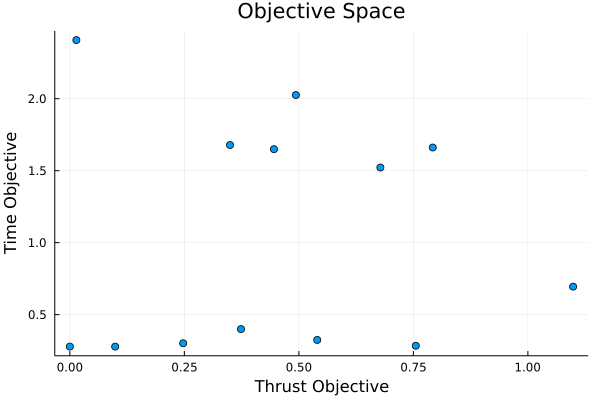

In [11]:
using Plots
scatter(thrust_obj.*5230, time_obj.*1.248e7,  
    xlabel="Thrust Objective", 
    #xlim = (0.0,1.05),
    ylabel="Time Objective",
    #ylim = (0.0,1.05),
    title="Objective Space",
    legend = false
    )
#savefig("BestFitness.png")

In [5]:
using JSON, GeneticDeorbit, Plots, Statistics, Evolutionary
time_obj2 = []
thrust_obj2 = []
Threads.@threads for f in saved_files
    data = JSON.parsefile(f)
    selected = rouletteinv(vcat(data["pop_fit_hist"][end]...),30)
    avg_gene1 = mean(data["gene1_history"][end][selected])
    avg_gene2 = mean(data["gene2_history"][end][selected])
    opt_sc = spacecraft(avg_gene1, avg_gene2)
    opt_traj = eval_fitness(opt_sc, data["weights"]./[1.248e7,5230])
    push!(time_obj2, opt_traj.time_fitness)
    push!(thrust_obj2, opt_traj.thrust_fitness)
end


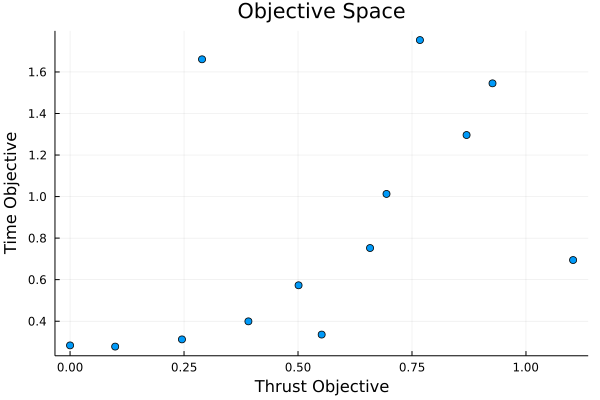

In [13]:
scatter(thrust_obj2.*5230, time_obj2.*1.248e7,  
    xlabel="Thrust Objective", 
    #xlim = (0.0,1.05),
    ylabel="Time Objective",
    #ylim = (0.0,1.05),
    title="Objective Space",
    legend = false
    )
#savefig("AvgFitness.png")

In [11]:
thrust_obj

13-element Vector{Any}:
 1.0
 0.9892925430210325
 0.9718929254302103
 0.7340344168260038
 0.8841300191204589
 0.9891013384321223
 0.01395793499043977
 0.27476099426386236
 0.2917782026768642
 0.38049713193116635
 0.5395793499043977
 0.3112810707456979
 0.1615678776290631

In [12]:
time_obj

13-element Vector{Any}:
 0.11538461538461538
 0.11538461538461538
 0.125
 0.1658653846153846
 0.1346153846153846
 0.11778846153846154
 1.0
 0.6971153846153846
 0.6850961538461539
 0.6322115384615384
 0.28846153846153844
 0.6899038461538461
 0.8413461538461539